In [2]:
import os
import glob
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import shapely
import numpy as np
import altair as alt
import py3dep
import geopy
from geopy.distance import distance as geopy_distance
from shapely.geometry import LineString,Point
import pandas as pd

# Define Radar Location

In [9]:
sail_dl_pt = Point(-106.987900, 38.956160)
descriptions = ['Doppler Lidar (SAIL)']
bearings = np.linspace(0,360, 73)

In [10]:
bearings

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
       220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
       275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
       330., 335., 340., 345., 350., 355., 360.])

# Create Azimuth Lines

In [11]:
radar_location_geopy = geopy.Point(sail_dl_pt.y, sail_dl_pt.x)
new_points = []
for angle in bearings:
    new_points.append(
        geopy_distance(
            kilometers=3
        ).destination(
            point=radar_location_geopy, 
            bearing=angle
        )
    )

In [12]:
xs, ys = zip(*[(x.longitude, x.latitude) for x in new_points])
radar_lines_gdf = gpd.GeoDataFrame(
    geometry = [ LineString([sail_dl_pt, distant_pt]) for distant_pt in gpd.points_from_xy(xs, ys)]
).set_crs('EPSG:4326')

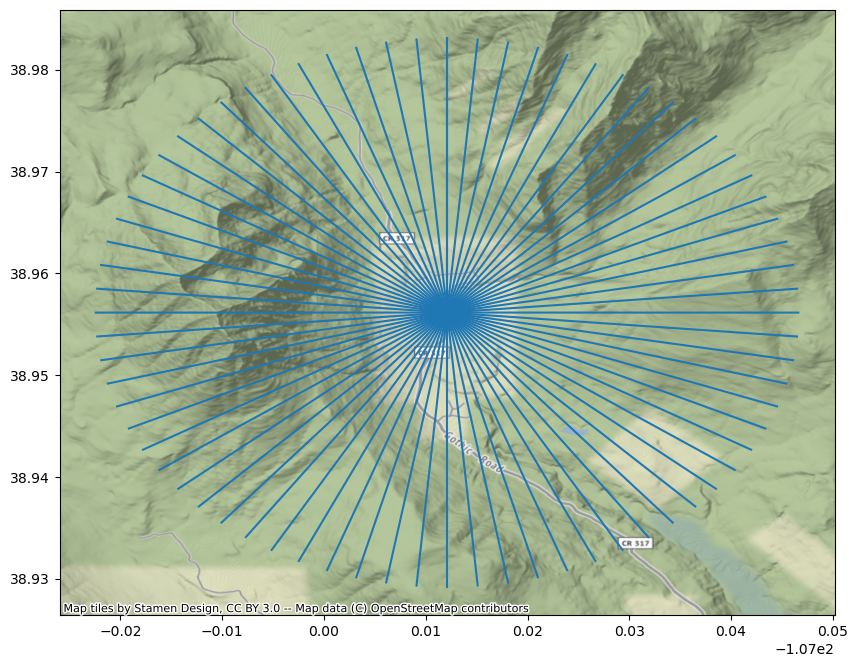

In [13]:
radar_lines_gdf.plot(figsize=(10,10), legend=True)
ctx.add_basemap(plt.gca(), crs=radar_lines_gdf.crs)

# Extract elevation profiles for each line

In [14]:
elevation_profiles = [
    py3dep.elevation_profile(
        radar_line, 
        spacing=10, 
        crs=radar_lines_gdf.crs
    ) for radar_line in radar_lines_gdf.geometry
]

In [17]:
elevation_profiles = [elev_prof.to_dataframe().reset_index() for elev_prof in elevation_profiles]

In [18]:
for elevation_df,x in zip(elevation_profiles, bearings):
    elevation_df.insert(0, 'Bearing', x)

# Find obstruction angles for each elevation profile

In [19]:
def find_obstruction_point(elevation_df):
    # Find angle from start point to all points along linear topography
    start_point = elevation_df.iloc[0] 
    start_point_elevation = elevation_df.iloc[0]['elevation']
    end_point_elevation = elevation_df.iloc[-1]['elevation']
    distance = elevation_df['distance'].max()

    elevation_df['elevation_angle_from_dl'] = elevation_df.apply(
        lambda row: np.rad2deg(np.arctan(
            (row['elevation'] - start_point['elevation']) / (row['distance'] - start_point['distance'])
        )), 
        axis=1
    )

    # Find lowest measurement height above Doppler lidar location assuming each maximum is THE obstructing maximum
    elevation_df['lowest_measurement_height'] = elevation_df.apply(
        lambda row: distance*np.tan(np.deg2rad(row['elevation_angle_from_dl'])) + (start_point_elevation - end_point_elevation),
        axis = 1
    )
    return elevation_df.sort_values('elevation_angle_from_dl', ascending=False).head(1).iloc[0].elevation_angle_from_dl

# Examine obstruction elevation angles for all bearings

In [20]:
obstructions_df = pd.DataFrame({'bearing': [], 'obstruction_angle': []})
for df in elevation_profiles:
    obstructions_df = obstructions_df.append({
            'bearing': df['Bearing'].iloc[0], 
            'obstruction_angle': find_obstruction_point(df)
        },
        ignore_index=True
    )
    

/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_9521/4046938950.py:10: RuntimeWarning: invalid value encountered in double_scalars
  (row['elevation'] - start_point['elevation']) / (row['distance'] - start_point['distance'])
/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_9521/3784123161.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obstructions_df = obstructions_df.append({
/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_9521/4046938950.py:10: RuntimeWarning: invalid value encountered in double_scalars
  (row['elevation'] - start_point['elevation']) / (row['distance'] - start_point['distance'])
/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_9521/3784123161.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obstructions_df = obstructions_df.append({
/var/folde

In [24]:
alt.Chart(obstructions_df).mark_point().encode(
    alt.X('bearing:Q', scale=alt.Scale(domain=[0,360], nice=False)),
    alt.Y('obstruction_angle:Q')
).properties(width=750)

/Users/elischwat/mambaforge/envs/arm/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)